### Импорт необходимых библиотек

In [47]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [34]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("train.csv", index_col="PassengerId")
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Целевым значением для нас будет значение Survived - то, выжил пассажир или нет. Вынесем этот столбец в отдельную переменную y, а в переменную X запишем все столбцы из таблицы data кроме столбца target

In [3]:
target = "Survived"

y = data[target]
X = data.drop(target, axis=1)

In [8]:
# столбце Cabin всего 204 непустых значения, этот столбец мы удалим. Также удалим столбцы Name и Ticket.
X.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 149.3 KB


### Чистка данных, обработка пропусков

In [5]:
X.drop(["Cabin", "Name", "Ticket"], axis=1, inplace=True)

In [6]:
# Поле возраста заполним средним значением
age_mean = X["Age"].mean()

print(age_mean)

X["Age"].fillna(age_mean, inplace=True)

29.69911764705882


In [7]:
# Анализ поля Embarked. Чаще всего встречается значение S. Заполним им пропущенные значения
X["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
X["Embarked"].fillna("S", inplace=True)

### Замена категориальных признаков 

In [10]:
sex_map = {
    "female": 1,
    "male": 0,
}

X["Sex"] = X["Sex"].map(sex_map)

In [11]:
X = pd.get_dummies(X)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,0,1
2,1,1,38.0,1,0,71.2833,1,0,0
3,3,1,26.0,0,0,7.9250,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1
5,3,0,35.0,0,0,8.0500,0,0,1


Несмотря на то, что столбец Pclass является числовым, его тоже хорошо бы рассматривать как категориальный, поскольку класс пассажира - это именно категория, а не непрерывное значение. Для этого зададим для этого столбца тип category, чтобы функция pd.get_dummies поняла, что этот столбец тоже нужно обработать.

In [12]:
X["Pclass"] = X["Pclass"].astype("category")
X = pd.get_dummies(X)
X.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,0,1,0,0,1
2,1,38.0,1,0,71.2833,1,0,0,1,0,0
3,1,26.0,0,0,7.9250,0,0,1,0,0,1
4,1,35.0,1,0,53.1000,0,0,1,1,0,0
5,0,35.0,0,0,8.0500,0,0,1,0,0,1


### Моделирование

#### Разобьём наши данные на тренировочную и валидационную выборки

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

#### Логистическая регрессия

In [18]:
lr = LogisticRegression(solver="liblinear")
lr.fit(X_train, y_train)

y_pred = lr.predict(X_valid)

In [19]:
#Для подсчёта правильных ответов будем использовать метрику accuracy
accuracy_score(y_valid, y_pred)

0.8026905829596412

In [23]:
#Предсказание на тренировочном датасете
y_pred_train = lr.predict(X_train)
accuracy_score(y_train, y_pred_train)

0.7410179640718563

Как мы видим, точность на тренировочной и обучающей выборках чуть больше чем немного - это означает, что модель переобучилась.

### Использование Support Vector Machine

In [22]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

In [24]:
clf = SVC(gamma="auto")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)
y_pred_train = clf.predict(X_train)

In [25]:
accuracy_score(y_valid, y_pred)

0.7847533632286996

In [26]:
accuracy_score(y_train, y_pred_train)

0.7874251497005988

В данной модели чуть нижу точность но нет переобучения, сделаем поднастрйоку модели

In [27]:
c_values = np.logspace(-2, 5, 36)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(c_values):
    clf = SVC(C=value, gamma="auto")
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 5 == 0:
        print('C = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

C = 0.01
	acc_valid = 0.600896860986547
	acc_train = 0.6212574850299402

C = 0.1
	acc_valid = 0.7847533632286996
	acc_train = 0.7874251497005988

C = 1.0
	acc_valid = 0.7847533632286996
	acc_train = 0.7874251497005988

C = 10.0
	acc_valid = 0.8071748878923767
	acc_train = 0.812874251497006

C = 100.0
	acc_valid = 0.8161434977578476
	acc_train = 0.8203592814371258

C = 1000.0
	acc_valid = 0.8251121076233184
	acc_train = 0.8368263473053892

C = 10000.0
	acc_valid = 0.8340807174887892
	acc_train = 0.8473053892215568

C = 100000.0
	acc_valid = 0.8071748878923767
	acc_train = 0.8592814371257484



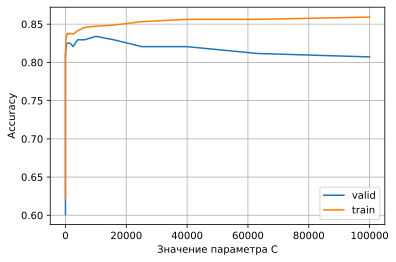

In [28]:
plt.plot(c_values, accuracy_on_valid, label="valid")
plt.plot(c_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра C')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

Как мы видим, точность на валидационных данных до определённого момента растёт, но затем начинает падать. Пик точности попадает приблизительно на значение  𝐶=10000 . Дальше мы видим спад точности на валидационных данных, однако, точность на тренировочных данных продолжает расти. Это означает, что модель начинает переобучаться.

### Масштабирование признаков с использованием RobustScaler

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = RobustScaler()
cols_for_scaling = ['Age', 'SibSp', 'Parch', 'Fare']

X_train[cols_for_scaling] = scaler.fit_transform(X_train[cols_for_scaling])
X_valid[cols_for_scaling] = scaler.transform(X_valid[cols_for_scaling])

In [36]:
X_train[cols_for_scaling].describe()

,Age,SibSp,Parch,Fare
count,668.000000,668.000000,668.000000,668.000000
mean,-0.017145,0.553892,0.372754,0.787570
std,1.000766,1.185279,0.795588,2.285892
min,-2.252240,0.000000,0.000000,-0.637874
25%,-0.592240,0.000000,0.000000,-0.286822
50%,0.000000,0.000000,0.000000,0.000000
75%,0.407760,1.000000,0.000000,0.713178
max,3.869299,8.000000,6.000000,22.056664


Как мы видим, после масштабирования мода каждого из масштабируемых признаков стала равной 0.

### Классификация с помощью KNN

In [37]:
# Построим модель для различных K, чтобы подобрать наиболее удачное значение.
k_values = np.arange(1, 11)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(k_values):
    clf = KNeighborsClassifier(n_neighbors=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 2 == 0:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 1
	acc_valid = 0.7623318385650224
	acc_train = 0.9730538922155688

K = 3
	acc_valid = 0.8161434977578476
	acc_train = 0.875748502994012

K = 5
	acc_valid = 0.8071748878923767
	acc_train = 0.8637724550898204

K = 7
	acc_valid = 0.7847533632286996
	acc_train = 0.8323353293413174

K = 9
	acc_valid = 0.7802690582959642
	acc_train = 0.8173652694610778



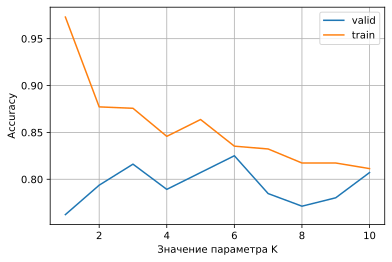

In [38]:
plt.plot(k_values, accuracy_on_valid, label="valid")
plt.plot(k_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра K')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

Мы видим, что при малых значениях K модель склонна к переобучению. Оптимальном выбором является число $K = 6$. Построим модель ещё раз, используя эти знания.

In [39]:
clf = KNeighborsClassifier(n_neighbors=6)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)

accuracy_score(y_valid, y_pred)

0.8251121076233184

### Деревья решений и случайный лес

In [41]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [44]:
# Деревья большой глубины склонны к переобучению: модель просто слишком детально подстраивается под тренировочные данные.
max_depth_values = np.arange(2, 20)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(max_depth_values):
    clf = DecisionTreeClassifier(max_depth=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 4 == 2:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 4
	acc_valid = 0.8071748878923767
	acc_train = 0.842814371257485

K = 8
	acc_valid = 0.757847533632287
	acc_train = 0.8967065868263473

K = 12
	acc_valid = 0.7443946188340808
	acc_train = 0.9580838323353293

K = 16
	acc_valid = 0.7309417040358744
	acc_train = 0.9790419161676647



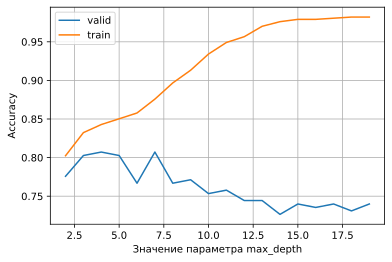

In [43]:
plt.rcParams['figure.figsize'] = 6, 4

plt.plot(max_depth_values, accuracy_on_valid, label="valid")
plt.plot(max_depth_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра max_depth')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

#### Оптимальная глубина дерева для нас равна 7, после Accuracy начинает падать

In [45]:
clf = DecisionTreeClassifier(max_depth=7)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.8071748878923767

### Random Forest

Зададим сетку параметров, по которой мы хотели бы провести поиск

In [48]:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}

clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameters,
    scoring='accuracy',
    cv=5,
)

In [49]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [53]:
clf.best_params_

{'max_depth': 7, 'max_features': 5, 'n_estimators': 150}

In [55]:
clf = RandomForestClassifier(max_depth=7, max_features=5, n_estimators=150)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)
accuracy_score(y_valid, y_pred)

0.820627802690583

RandomForestClassifier показал лучше результаты